# Time series Prediction using AutoML library [TPOT](http://epistasislab.github.io/tpot/).


In [39]:
# Import necessary libraries

import os 
from IPython.display import Image
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

# Plots
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 18, 7

import warnings
warnings.filterwarnings('ignore')

# we will use regression model on the time series
from tpot import TPOTRegressor

import sidetable as stb
import plotly.express as px

from statsmodels.tsa.stattools import pacf # to evaluate the autocorrelation of target column
import plotly.graph_objects as go

In [2]:
from datetime import datetime
def dateparse(d,t):
    dt = d + " " + t
    return pd.datetime.strptime(dt, '%d/%m/%Y %H.%M.%S')

# loading data set and parsing date and time column to create datetime index
df = pd.read_csv('data/AirQualityUCI_combined.csv',sep=';',decimal=',', parse_dates={'datetime': ['Date', 'Time']})
df.drop(['Unnamed: 15'],axis=1, inplace=True)

# From the dataset description we know that unknown/missing values are marked as -200.0.
# we fill those values using ffill: propagate last valid observation forward
df = df.replace({-200.0:np.nan})
df = df.fillna(method='ffill')
df = df.dropna(axis=0)
df = df.set_index('datetime')
ground_truth = ['CO(GT)','C6H6(GT)','NMHC(GT)','NOx(GT)','NO2(GT)']
df = df.drop(ground_truth,axis=1)
df = df.loc['2004-04-01 00:00:00':'2005-01-07 00:00:00']
df = df.sort_index()
df = ( df - df.min() ) / (df.max() - df.min()) # Min-Max normalize the dataset
df_orig = df.copy()

In [24]:
label_col = 'PT08.S2(NMHC)'
len_forecast = 500
window_size = 100

In [25]:
def create_corr_plot(series, plot_pacf=False):
    corr_array = pacf(series.dropna(), alpha=0.05) if plot_pacf else pacf(series.dropna(), alpha=0.05)
    lower_y = corr_array[1][:,0] - corr_array[0]
    upper_y = corr_array[1][:,1] - corr_array[0]

    fig = go.Figure()
    [fig.add_scatter(x=(x,x), y=(0,corr_array[0][x]), mode='lines',line_color='#3f3f3f') 
     for x in range(len(corr_array[0]))]
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=corr_array[0], mode='markers', marker_color='#1f77b4',
                   marker_size=12)
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=upper_y, mode='lines', line_color='rgba(255,255,255,0)')
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=lower_y, mode='lines',fillcolor='rgba(32, 146, 230,0.3)',
            fill='tonexty', line_color='rgba(255,255,255,0)')
    fig.update_traces(showlegend=False)
    fig.update_xaxes(range=[-1,42])
    fig.update_yaxes(zerolinecolor='#000000')
    
    title='Partial Autocorrelation (PACF)' if plot_pacf else 'Autocorrelation (ACF)'
    fig.update_layout(title=title)
    fig.show()
    
create_corr_plot(df_orig[label_col])

In [26]:
def shift_period(df: pd.DataFrame ,columns: list, lag: int) -> pd.DataFrame:
    for col in columns:
        for i in range(1,lag+1):
            df[f'{col}_{i}'] = df[col].shift(-i)
    return df

df_shifted = shift_period(df_orig,[label_col,'PT08.S1(CO)','PT08.S3(NOx)'],3)
    

In [38]:
df_shifted.head()

,PT08.S1(CO),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,PT08.S2(NMHC)_1,PT08.S2(NMHC)_2,PT08.S2(NMHC)_3,PT08.S1(CO)_1,PT08.S1(CO)_2,PT08.S1(CO)_3,PT08.S3(NOx)_1,PT08.S3(NOx)_2,PT08.S3(NOx)_3
datetime,,,,,,,,,,,,,,,,,
2004-04-04 00:00:00,0.423953,0.276409,0.238035,0.462680,0.304952,0.382743,0.594969,0.425450,0.249589,0.216201,0.222222,0.417340,0.343865,0.350478,0.257094,0.278695,0.272342
2004-04-04 01:00:00,0.417340,0.249589,0.257094,0.449640,0.278454,0.365044,0.628931,0.425499,0.216201,0.222222,0.161467,0.343865,0.350478,0.279941,0.278695,0.272342,0.325286
2004-04-04 02:00:00,0.343865,0.216201,0.278695,0.426709,0.230669,0.349558,0.669182,0.429977,0.222222,0.161467,0.143952,0.350478,0.279941,0.266716,0.272342,0.325286,0.359593
2004-04-04 03:00:00,0.350478,0.222222,0.272342,0.436151,0.247611,0.338496,0.701887,0.431946,0.161467,0.143952,0.188287,0.279941,0.266716,0.313740,0.325286,0.359593,0.295637
2004-04-04 04:00:00,0.279941,0.161467,0.325286,0.403327,0.206777,0.329646,0.705660,0.423482,0.143952,0.188287,0.162562,0.266716,0.313740,0.284350,0.359593,0.295637,0.333757


In [28]:

corr = df_shifted.corr()
corr.style.background_gradient(cmap='coolwarm',axis=None).set_precision(2)

,PT08.S1(CO),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,PT08.S2(NMHC)_1,PT08.S2(NMHC)_2,PT08.S2(NMHC)_3,PT08.S1(CO)_1,PT08.S1(CO)_2,PT08.S1(CO)_3,PT08.S3(NOx)_1,PT08.S3(NOx)_2,PT08.S3(NOx)_3
PT08.S1(CO),1.00,0.92,-0.80,0.75,0.91,0.03,0.11,0.13,0.80,0.63,0.47,0.89,0.73,0.58,-0.73,-0.60,-0.47
PT08.S2(NMHC),0.92,1.00,-0.84,0.79,0.90,0.16,-0.09,0.09,0.87,0.68,0.51,0.80,0.64,0.49,-0.75,-0.61,-0.48
PT08.S3(NOx),-0.80,-0.84,1.00,-0.67,-0.82,-0.17,-0.07,-0.30,-0.73,-0.58,-0.42,-0.71,-0.57,-0.44,0.90,0.74,0.59
PT08.S4(NO2),0.75,0.79,-0.67,1.00,0.65,0.44,-0.04,0.52,0.68,0.52,0.39,0.65,0.51,0.38,-0.60,-0.49,-0.38
PT08.S5(O3),0.91,0.90,-0.82,0.65,1.00,-0.07,0.12,0.04,0.78,0.62,0.48,0.80,0.66,0.53,-0.73,-0.61,-0.50
T,0.03,0.16,-0.17,0.44,-0.07,1.00,-0.66,0.54,0.15,0.13,0.12,0.02,0.01,-0.00,-0.16,-0.15,-0.14
RH,0.11,-0.09,-0.07,-0.04,0.12,-0.66,1.00,0.21,-0.08,-0.07,-0.05,0.11,0.11,0.11,-0.07,-0.07,-0.07
AH,0.13,0.09,-0.30,0.52,0.04,0.54,0.21,1.00,0.07,0.06,0.04,0.11,0.09,0.07,-0.27,-0.25,-0.23
PT08.S2(NMHC)_1,0.80,0.87,-0.73,0.68,0.78,0.15,-0.08,0.07,1.00,0.87,0.68,0.92,0.81,0.64,-0.84,-0.75,-0.61
PT08.S2(NMHC)_2,0.63,0.68,-0.58,0.52,0.62,0.13,-0.07,0.06,0.87,1.00,0.87,0.80,0.92,0.81,-0.73,-0.84,-0.75


In [29]:
features = df_shifted.drop(label_col,axis=1)
target = df_shifted[label_col]

In [30]:
X_train, X_test, y_train, y_test = train_test_split(features, target,
                                                    train_size=0.75, test_size=0.25)

In [31]:
tpot = TPOTRegressor(generations=4, population_size=100, verbosity=2,)#config_dict="TPOT cuML")
tpot.fit(X_train, y_train)

Imputing missing values in feature set


Optimization Progress:   0%|          | 0/500 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -0.0003789773273596291

Generation 2 - Current best internal CV score: -0.0003788310135402316

Generation 3 - Current best internal CV score: -0.0003774695281685788

Generation 4 - Current best internal CV score: -0.0003385226905287119

Best pipeline: LassoLarsCV(PolynomialFeatures(ExtraTreesRegressor(input_matrix, bootstrap=False, max_features=0.05, min_samples_leaf=6, min_samples_split=9, n_estimators=100), degree=2, include_bias=False, interaction_only=False), normalize=False)


TPOTRegressor(generations=4, verbosity=2)

In [32]:
print("TPOT cross-validation MSE")
print(tpot.score(X_test, y_test))

TPOT cross-validation MSE
Imputing missing values in feature set
-0.00032540799613094075


In [33]:

print('MSE:')
print(mean_squared_error(y_test, tpot.predict(X_test)))
print('MAE:')
print(mean_absolute_error(y_test, tpot.predict(X_test)))

MSE:
Imputing missing values in feature set
0.00032540799613094075
MAE:
Imputing missing values in feature set
0.011482041635492515


In [34]:
tpot.export('tpot_optimized_pipeline.py')

In [35]:
df_predicted = pd.DataFrame({'Predicted':tpot.predict(X_test)})
df_predicted.index = y_test.index

Imputing missing values in feature set


In [36]:
df_result = pd.merge(df_orig,df_predicted,how='left',left_index = True, right_index = True)

In [37]:
fig = px.line(df_result.dropna(axis=0), x=df_result.dropna(axis=0).index, y = [label_col,'Predicted'])
fig.show()

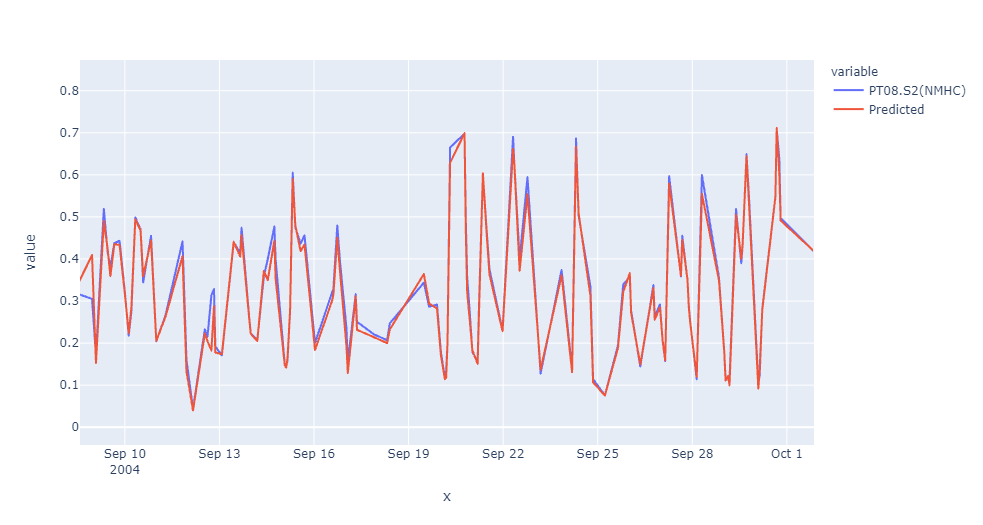

In [41]:
Image(filename='figures/tpot_prediction.png') 